# Any natural number can be expressed as a product of prime numbers, $N = \Pi_{k=1}^K p_k ^{n_k}$.
#### here $p_k$ is a prime number and $n_k$ is a natural number.

## Factor a number $N=p\cdot q$, where $p, q$ are prime number.

(This is used in RSA cryptosystem)

### IDEA:

If $N$ is not a prime number, then $N$ has some interesting properties.\
Let us try to find some variable $x$ that satisfies $x^2\equiv 1 (\text{ mod }N)$. One can easily find that $x=1$ satisfies the relation for any $N$, but this is trivial and doesn't give us much hints. what about $x\equiv N-1 (\text{ mod }N)$, or $x \equiv -1 (\text{ mod }N)$?

We see that $$x^2 \equiv (N-1)^2 (\text{ mod }N) \equiv N^2 - 2N + 1(\text{ mod }N) \equiv 1 (\text{ mod }N)$$

This means $x^2 -1 \equiv 0 (\text{ mod } N)$, in other words, $N$ divides $(x+1)(x-1)$. This implies either $x+1$ shares a common factor with $N$ or $x-1$ shares a common factor with $N$.

For a number $N$ that cannot be expressed as a product of two prime numbers, this way of thining will normally bring you nowhere, but for $N$ that can is an interesting way to think about it.

If $N=p \cdot q$, wher $p$ and $q$ are both prime numbers, then $x+1$ is a prime number or $x-1$ is a prime number.

### Process:
1. pick a random number $x$ (natural number).
2. compute $x^k$ for $k \in \{0, 1, 2, \ldots,r \}$ until we get $x^r \equiv 1 (\text{ mod } N)$
3. if $r$ is even, then check $x^{r/2} \not\equiv \pm1 (\text{ mod } N)$
4. if $x^{r/2} \not\equiv \pm1 (\text{ mod } N)$ holds, then $(x^{r/2} - 1)(x^{r/2} + 1) \equiv 0 (\text{ mod } N)$, so at least one of $(x^{r/2} - 1)$ or $(x^{r/2} + 1)$ shares a prime factor with $N$.

Classic algorithm

In [37]:
import math
from random import randint as randint

In [59]:
def product(elements):
    result = 1
    while elements:
        element = elements.pop()
        result *= element
    return result

def factor_N(m, N, visited, factors):
    if m not in visited:
        for _ in range(N):
            # find the mapped value
            candidate = m ** _ % N

            if candidate not in visited:
                # append it to visited if this is the first time finding
                visited.add(candidate)
            else:
                # if we already have the element, then the cycle starts.
                break

        period = len(visited)

        # if period has even length,
        if period % 2 == 0:
            x = (m ** int(period / 2)) % N
            x_plus  = x + 1 % N
            x_minus = x - 1 % N
            plus  = math.gcd(x_plus,  N)
            minus = math.gcd(x_minus, N)
            if plus not in factors:
                factors.add(plus)
            if minus not in factors:
                factors.add(minus)
    return factors, visited

In [132]:
N = 15
# m = 13

In [133]:
done = False
factors = set({1})
visited = set()
tried = set({1, N})
factors_product = 1

In [134]:
while factors_product != N and not done:
    m = randint(3,N-1)
    if m not in tried:
        tried.add(m)
    # check if m is a coprime with N
    if math.gcd(m,N) == 1:
        factors, visited = factor_N(m, N, visited, factors)

        # check if the product of factors equals N
        factors_product = product(factors.copy())
    if len(tried) == N:
        print("N cannot be factored as p*q where both p and q are prime")
        done = True
    
        
        
factors.remove(1)
print(factors)

{3, 5}


#### Now this method is quite slow if $N$ is very large, because we have to check $x^0, x^1, \ldots, x^r$ until we get $x^r \equiv 1 (\text{ mod } N)$. Finding this period is very heavy on computing time (typically grows large as $N$ grows large).

Can we use quantum computers to create a super-position of a set of natural number to a unique set of $\left\{x^0(\text{ mod } N), x^1 (\text{ mod } N), \ldots, x^M (\text{ mod } N) \right\}$?

In [136]:
from qiskit import BasicAer, QuantumCircuit, execute

In [137]:
%matplotlib inline

In [141]:
N

15

In [143]:
m = 3

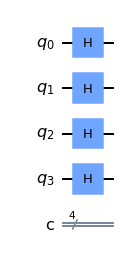

In [145]:
# find the amount of binary variables required to express N
n = len(format(N, 'b'))

# create a circuit with n qubits and n ancilla qubits
qc = QuantumCircuit(n,n)

# first super-position all qubits so we have a uniform distribution for all possible numbers (in binary format)
for q in range(n):
    qc.h(q)
    
qc.draw('mpl')

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

### recall the step in the classical implementation that we computed `candidate = m ** _ % N`. If m is a coprime with N, then condidate follows a cycle, where it always start with 0 ($m^0 = 1$). Then the unique elements in this cycle forms an eignestate of this operations (modulus of the exponential). Let the length of this cycle be denoted as $r$. Then for any state $x$, where $x \in \mathbb{Z}$, let $z$ be the binary representation of this state ($z \in \{0,1\}^n$, and $x = \sum_{i=1}^r 2^{r-i}z_i$).

### Let's call this operator $U$, where $U \ket{x} = \ket{mx \text{ mod }N}$. We then have the following representations:
- $U \ket{x} = \ket{mx \text{ mod }N}$
- $U^2 \ket{x} = \ket{m^2 x \text{ mod }N}$\
$\vdots$
- $U^{r-1} \ket{x} = \ket{m^{r-1}x \text{ mod }N}$
- $U^r \ket{x} = \ket{m^r x \text{ mod }N} = \ket{x \text{ mod } N}$

We can see that the state $\ket{u}$ is an eigenstate of $U$.

let $\ket{u} = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \ket{m^k \text{ mod } N}$.

$$
\begin{aligned}
&& U\ket{u} =& \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} U\ket{m^k \text{ mod } N}\\
&& = & \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \ket{m^{k+1} \text{ mod } N}\\
&& = & \frac{1}{\sqrt{r}} \sum_{k=1}^{r} \ket{m^{k} \text{ mod } N}\\
&& = & \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} \ket{m^{k} \text{ mod } N}\\
&& = & \ket{u}
\end{aligned}
$$

If we want $\ket{m^{k} \text{ mod } N}$ to form a basis, then we can express $\ket{m^{k} \text{ mod } N}$ using the Fourier basis.

By letting $\ket{u} = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} \ket{m^k \text{ mod } N}$, we see that 

$$
\begin{aligned}
&& U\ket{u} =& \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} U\ket{m^k \text{ mod } N}\\
&& = & \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} \ket{m^{k+1} \text{ mod } N}\\
&& = & \frac{1}{\sqrt{r}} \sum_{k=1}^{r} e^{-\frac{2 \pi i (k-1)}{r}} \ket{m^{k} \text{ mod } N}\\
&& = & e^{\frac{2 \pi i}{r}} \cdot \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-\frac{2 \pi i k}{r}} \ket{m^{k} \text{ mod } N}\\
&& = & e^{\frac{2 \pi i}{r}} \ket{u}
\end{aligned}
$$


